<a href="https://colab.research.google.com/github/mdunand2/2024_MLEES/blob/main/Project/Landslide_Italy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Comparing performance of different ML algorithms for shallow landslide prediction #



To start with, let's import a few libraries that will be useful for the rest of the work and check that the correct versions are installed.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Downloading data ##

The data will be downloaded using the Pandas library. It will enable me to work easily with tabular data thanks to its DataFrame data structure, for example.

In [2]:
pip install pandas

Two sets of data will be downloaded:
- with SL: Rainfall events that caused a landslide (2294 occurrences)
- without SL: rainfall events that did not cause landslides (2294 occurrences)

Alessandro Mondini and Massimo Mellilo sent me some of the data they used for one of their research projects on landslide prediction in Italy. The following article explains their study: https://www.nature.com/articles/s41467-023-38135-y

The raw data they used are
1.   A list of landslides that occurred between February 2002 and December 2020 with the exact location and time of occurrence.
2.   Rainfall data from 2096 point measurement stations.

The two raw data sets have been fed into a tool called CTRL-T, which can be used to reconstruct rainfall events with the characteristics of intensity and duration.
Each rain event was then divided into two periods:
- the antecedent period
- the triggering period

Since it is difficult to precisely define the duration of these two periods, a variable (lag) was introduced to facilitate the process. The lag ranges from 1 to 24 hours and defines the duration of the trigger period. Each rainfall episode was then divided up in different ways according to the lag. For example, if a rain event lasts 10h: with a lag of 1, the trigger period lasts 1h and the previous period lasts 9h, with a lag of 2, the trigger period lasts 2h and the previous period lasts 8h, etc. until the lag that corresponds to the duration of the rain event or 24h.

The Italian researchers then divided all these data according to the lag used and created 24 models based on the 24 lags. For my part, I'm going to be training just one model in this project and the data I've been given are for lag 12.

It's clear that there are many more rain events that didn't cause landslides than those that did, but here it was decided to use the same number of occurrences for both so as not to skew the results. The 2,294 rain events that did not cause landslides were randomly selected for the Italian researchers.

In [3]:
import pandas as pd

# Provide access to google drive for direct data retrieval
from google.colab import drive
drive.mount('/content/drive')

# Import files with rainfall events that triggered shallow landslides (SL)
with_SL = pd.read_csv('/content/drive/MyDrive/si_12.csv', sep = ';')
# Import files with rainfall events that didn't trigger shallow landslides (SL)
without_SL = pd.read_csv('/content/drive/MyDrive/no_12_subsamp.csv', sep = ';')

Mounted at /content/drive


Let's see what the two previously downloaded datasets look like.

In [4]:
print("Rainfall events that triggered SL :")
with_SL.head()

Rainfall events that triggered SL :


,Dnl,Cnl,Dl,Cl,bit_lan,ID_raingauge,REN,type,date,year,month,day,hou,MAP,rdY,zone_Rei_Guz,Corine_LIV_2
0,18,38.8,12,17.0,1,4265480137173,227,N_0084,2008-06-09 16:00:00,2008,6,9,1,789.9,68,*,*
1,16,12.6,12,75.6,1,4265480137173,412,N_0185,2013-11-11 22:00:00,2013,11,11,2,789.9,68,*,*
2,38,84.4,12,13.8,1,4272970136917,130,N_5311,2012-07-24 09:00:00,2012,7,24,0,422.0,42,*,*
3,35,43.2,12,0.0,1,4272970136917,147,N_5416,2013-05-12 10:00:00,2013,5,12,1,422.0,42,*,*
4,49,42.8,12,41.8,1,4275720136456,97,N_3296,2009-04-21 21:00:00,2009,4,21,2,487.1,44,*,*


In [5]:
print("Rainfall events that didn't triggered SL :")
without_SL.head()

Rainfall events that didn't triggered SL :


,Dnl,Cnl,Dl,Cl,bit_lan,ID_raingauge,REN,type,date,year,month,day,hou,MAP,rdY,zone_Rei_Guz,Corine_LIV_2
0,68,18.6,12,0.0,0,4423720105164,220,no_frana,2010-01-18 10:00:00,2010,1,18,1,1530.2,94,*,*
1,152,15.6,12,0.0,0,3797270142892,147,no_frana,2006-12-25 00:00:00,2006,12,25,0,683.3,67,*,*
2,3,11.6,12,1.2,0,4581190098661,21,no_frana,2012-07-06 22:00:00,2012,7,6,2,1277.1,85,*,*
3,49,90.0,12,12.8,0,4531530075472,307,no_frana,2010-11-02 07:00:00,2010,11,2,0,1287.4,78,*,*
4,22,34.6,12,5.4,0,4612990123183,7,no_frana,2002-04-17 05:00:00,2002,4,17,0,1263.8,81,*,*


## Data processing ##

Now that the two databases have been correctly imported, it's important to prepare the data. To start with, we're going to merge these two tables into one.

In [6]:
# Concatenate the two DataFrames
total_SL = pd.concat([with_SL, without_SL], ignore_index=True)

# Display the merged DataFrame
total_SL

,Dnl,Cnl,Dl,Cl,bit_lan,ID_raingauge,REN,type,date,year,month,day,hou,MAP,rdY,zone_Rei_Guz,Corine_LIV_2
0,18,38.8,12,17.0,1,4265480137173,227,N_0084,2008-06-09 16:00:00,2008,6,9,1,789.9,68,*,*
1,16,12.6,12,75.6,1,4265480137173,412,N_0185,2013-11-11 22:00:00,2013,11,11,2,789.9,68,*,*
2,38,84.4,12,13.8,1,4272970136917,130,N_5311,2012-07-24 09:00:00,2012,7,24,0,422.0,42,*,*
3,35,43.2,12,0.0,1,4272970136917,147,N_5416,2013-05-12 10:00:00,2013,5,12,1,422.0,42,*,*
4,49,42.8,12,41.8,1,4275720136456,97,N_3296,2009-04-21 21:00:00,2009,4,21,2,487.1,44,*,*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4583,71,5.2,12,3.6,0,4452940104894,32,no_frana,2002-12-28 18:00:00,2002,12,28,1,650.2,61,*,*
4584,62,12.0,12,7.8,0,4382040104132,121,no_frana,2006-03-24 17:00:00,2006,3,24,1,968.8,68,*,*
4585,3,3.4,12,2.8,0,4412000118081,109,no_frana,2010-04-13 12:00:00,2010,4,13,1,549.2,52,*,*
4586,14,10.2,12,0.0,0,3825700155604,53,no_frana,2004-02-17 02:00:00,2004,2,17,0,915.6,78,*,*


It is necessary to prepare the data so as to keep only those variables that really interest me for this project.

*   Dnl : Antecedent period of the rainfall
*   Cnl : Cumulated intensity during the antecedent period
*   Dl : Triggering period of the rainfall
*   Cl : Cumulated intensity during the triggering period
*   bit_lan : If the rainfall, triggered a shallow landslide (SL), bit_lan = 1, and if not bit_lan = 0
*   date : Date and time of the beginning of the rainfall (à contrôler, Jacques me redis)

In [7]:
 # Select the columns that are important for the project
selected_SL = total_SL.iloc[:, [0, 1, 3, 4, 8]]

selected_SL.head()

,Dnl,Cnl,Cl,bit_lan,date
0,18,38.8,17.0,1,2008-06-09 16:00:00
1,16,12.6,75.6,1,2013-11-11 22:00:00
2,38,84.4,13.8,1,2012-07-24 09:00:00
3,35,43.2,0.0,1,2013-05-12 10:00:00
4,49,42.8,41.8,1,2009-04-21 21:00:00


### Splitting training/test sets for Random Forest and XGBoost

I decided to divide the data into 2 sets: 80% of the data for training and 20% for test.

I don't need to create a validation set for models with the Random Forest and XGBoost algorithms. In fact, the RandomizedSearch method that I use to optimise my hyperparameters itself creates a validation set.

In [10]:
from sklearn.model_selection import train_test_split

# Separate the data into two groups: with landslides (bit_lan=1) and without landslides (bit_lan=0)
with_landslide = selected_SL[selected_SL['bit_lan'] == 1]
without_landslide = selected_SL[selected_SL['bit_lan'] == 0]

# Divide each group into training data (80%) and test data (20%)
with_landslide_train, with_landslide_test = train_test_split(with_landslide, test_size=0.2, random_state=42)
without_landslide_train, without_landslide_test = train_test_split(without_landslide, test_size=0.2, random_state=42)

# Combine training, validation and test data for the two classes (with and without landslides)
train_df_2 = pd.concat([with_landslide_train, without_landslide_train], ignore_index=True)
test_df_2 = pd.concat([with_landslide_test, without_landslide_test], ignore_index=True)

# Display set sizes for verification
print(f"Size training set : {train_df_2.shape[0]}")
print(f"Size test set : {test_df_2.shape[0]}")

Size training set : 3670
Size test set : 918


It is still necessary to create the matrix X and y, X being the explanatory variables, i.e. Dnl, Cnl, Cl, and y the target values, i.e. bit_lan. for training and test

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Prepare the explanatory variables and the target variable
# The explanatory columns are Dnl, Cnl, Cl and the target variable is bit_lan

# For the training set
X_train = train_df_2[['Dnl', 'Cnl', 'Cl']]
y_train = train_df_2['bit_lan']

# For the test set
X_test = test_df_2[['Dnl', 'Cnl', 'Cl']]
y_test = test_df_2['bit_lan']

### Normalisation

Since it will be necessary to normalise the data for the two MLP models, I decide to normalise the data for all the models so that it will be easier to compare them afterwards.

In [12]:
from sklearn.preprocessing import StandardScaler

# Normalize the training, validation, and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##ML models constructions

Now that the data is ready to be used with different models, it is time to decide which models to train.

I will start with a Random Forest algorithm. This algorithm is based on decision trees. It builds a "forest" composed of multiple trees, where each tree is trained on a different sample of the data. The final prediction is obtained by combining the predictions from all the trees.

Next, I will proceed with a XGBoost algorithm, which sequentially builds decision trees, giving more weight to the errors of the previous trees. It is more sophisticated than a Random Forest algorithm, but we will see if its performance is better on a dataset like mine.

Finally, two MLP models, which are artificial neural networks, will be built. In these models, the data passes through several fully connected layers of neurons, and the use of nonlinear activation functions allows the model to capture complex relationships in the data. The first model will be similar to the one created by the Italian researchers to compare the results, and the second will be slightly more complex.

## Random Forest model


In [14]:
# Initialization of the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [15]:
# Train the model on the training set
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [16]:
# Evaluation of the model

# Predictions on the test set
y_test_pred = model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on the test set: {test_accuracy:.4f}")

# Classification report for the test set
print("\nClassification report for the test set:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix for the test set
print("\nConfusion matrix for the test set:")
print(confusion_matrix(y_test, y_test_pred))


Accuracy on the test set: 0.7996

Classification report for the test set:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       459
           1       0.80      0.79      0.80       459

    accuracy                           0.80       918
   macro avg       0.80      0.80      0.80       918
weighted avg       0.80      0.80      0.80       918


Confusion matrix for the test set:
[[370  89]
 [ 95 364]]


### Optimization Random Forest model

The model achieves an accuracy of 0.8 on the test set. By optimizing the hyperparameters, it is likely possible to improve the model's performance. To achieve this, I will use RandomizedSearchCV to find the parameters that yield the best score.



In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# 1. Define the parameters and their possible values for the search
param_distributions = {
    'n_estimators': [50, 80, 100, 200],          # Number of trees
    'max_depth': [None, 5, 10, 15, 20],          # Maximum depth of each tree
    'min_samples_split': [5, 7, 9, 10, 12],      # Minimum number of samples required to split a node
    'min_samples_leaf': [2],                     # Minimum number of samples required at a leaf node (fixed setting)
    'max_features': ['log2'],                    # Maximum number of features considered for splitting (fixed setting)
    'bootstrap': [True]                          # Resampling method (fixed setting)
}

# 2. Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# 3. Configure RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50,                   # Number of combinations to test (higher = more precision but longer time)
    scoring='accuracy',          # Evaluation metric
    cv=5,                        # 5-fold cross-validation
    random_state=42,
    n_jobs=-1                    # Use all processor cores
)

# 4. Perform the random search on the training set
random_search.fit(X_train_scaled, y_train)

# 5. Display the best hyperparameters found and the corresponding accuracy
print("Best hyperparameters: ", random_search.best_params_)
print("Accuracy with best parameters: ", random_search.best_score_)

Best hyperparameters:  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
Accuracy with best parameters:  0.8204359673024524


Some hyperparameters have been fixed because by changing the hyperparameter range according to the results, these hyperparameters never change

Once the best parameters have been found, the model is retrained with these new hyperparameters.

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create a new Random Forest model with the best hyperparameters found
best_params = random_search.best_params_
final_model = RandomForestClassifier(**best_params, random_state=42)

# Train the final model on the training set
final_model.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
y_test_pred = final_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy with the final model: {test_accuracy:.4f}")

# Display the classification report for more detailed metrics
print("\nClassification report for the test set:")
print(classification_report(y_test, y_test_pred))

# Display the confusion matrix for the test set
print("\nConfusion matrix for the test set:")
print(confusion_matrix(y_test, y_test_pred))


Test accuracy with the final model: 0.8170

Classification report for the test set:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       459
           1       0.82      0.81      0.82       459

    accuracy                           0.82       918
   macro avg       0.82      0.82      0.82       918
weighted avg       0.82      0.82      0.82       918


Confusion matrix for the test set:
[[377  82]
 [ 86 373]]


Comparing the accuracy results on the test set, we can see that the optimization worked. The test set accuracy improved from 79.96% before to 81.7% now.

### Evaluation of the model's performance

#### Confusion Matrix

The first graph to be created is the confusion matrix. It evaluates the classification performance by comparing the model's predictions with the actual values.

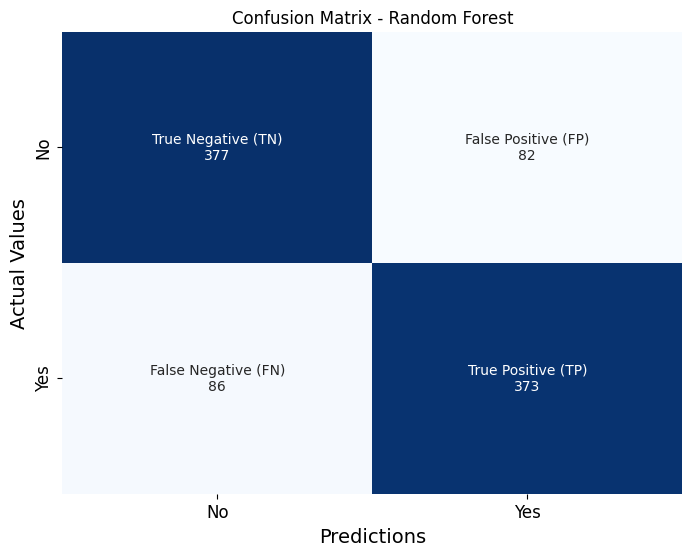

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Define labels for each cell (True Positive, False Positive, etc.)
labels = ['True Negative (TN)', 'False Positive (FP)', 'False Negative (FN)', 'True Positive (TP)']
label_counts = [f"{label}\n{value}" for label, value in zip(labels, conf_matrix.flatten())]
label_counts = np.array(label_counts).reshape(2, 2)

# Plot the confusion matrix with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=label_counts, fmt='', cmap='Blues', cbar=False,
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])

plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predictions")
plt.ylabel("Actual Values")
plt.show()



The model performs quite well. Moreover, in risk assessment studies, it is preferable to have more false negatives (predicted landslides that do not occur) than false positives (no landslides predicted but actually occur).

Il faut avoir une balance entre précision et recall et ici on a cela.

#### Features importances

  Feature  Importance
2      Cl    0.575071
1     Cnl    0.284388
0     Dnl    0.140541


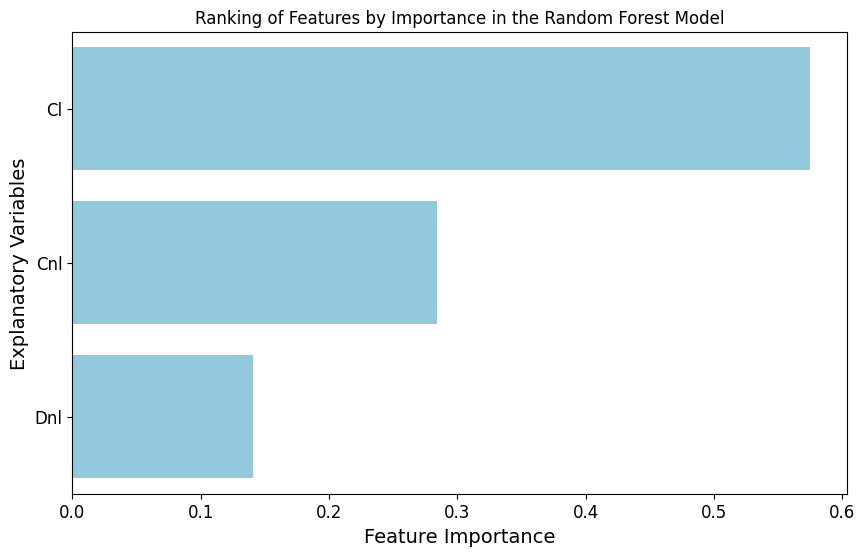

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the feature importances
importances_rf = final_model.feature_importances_

# Get the feature names (columns used for training)
feature_names = X_train.columns

# Associate each feature name with its importance
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances_rf})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

# Plot a bar chart of feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, color='skyblue')
plt.title("Ranking of Features by Importance in the Random Forest Model")
plt.xlabel("Feature Importance")
plt.ylabel("Explanatory Variables")
plt.show()

The feature importance will help determine which variable has the most significance in the model. This can, for example, help in setting thresholds.

### Partial Dependance Plot (PDP)

Partial Dependence Plots (PDP) are used to understand how one or more features influence the average prediction of a model. In this case, I plotted the PDPs for the 3 features Cl, Cnl and Dnl.

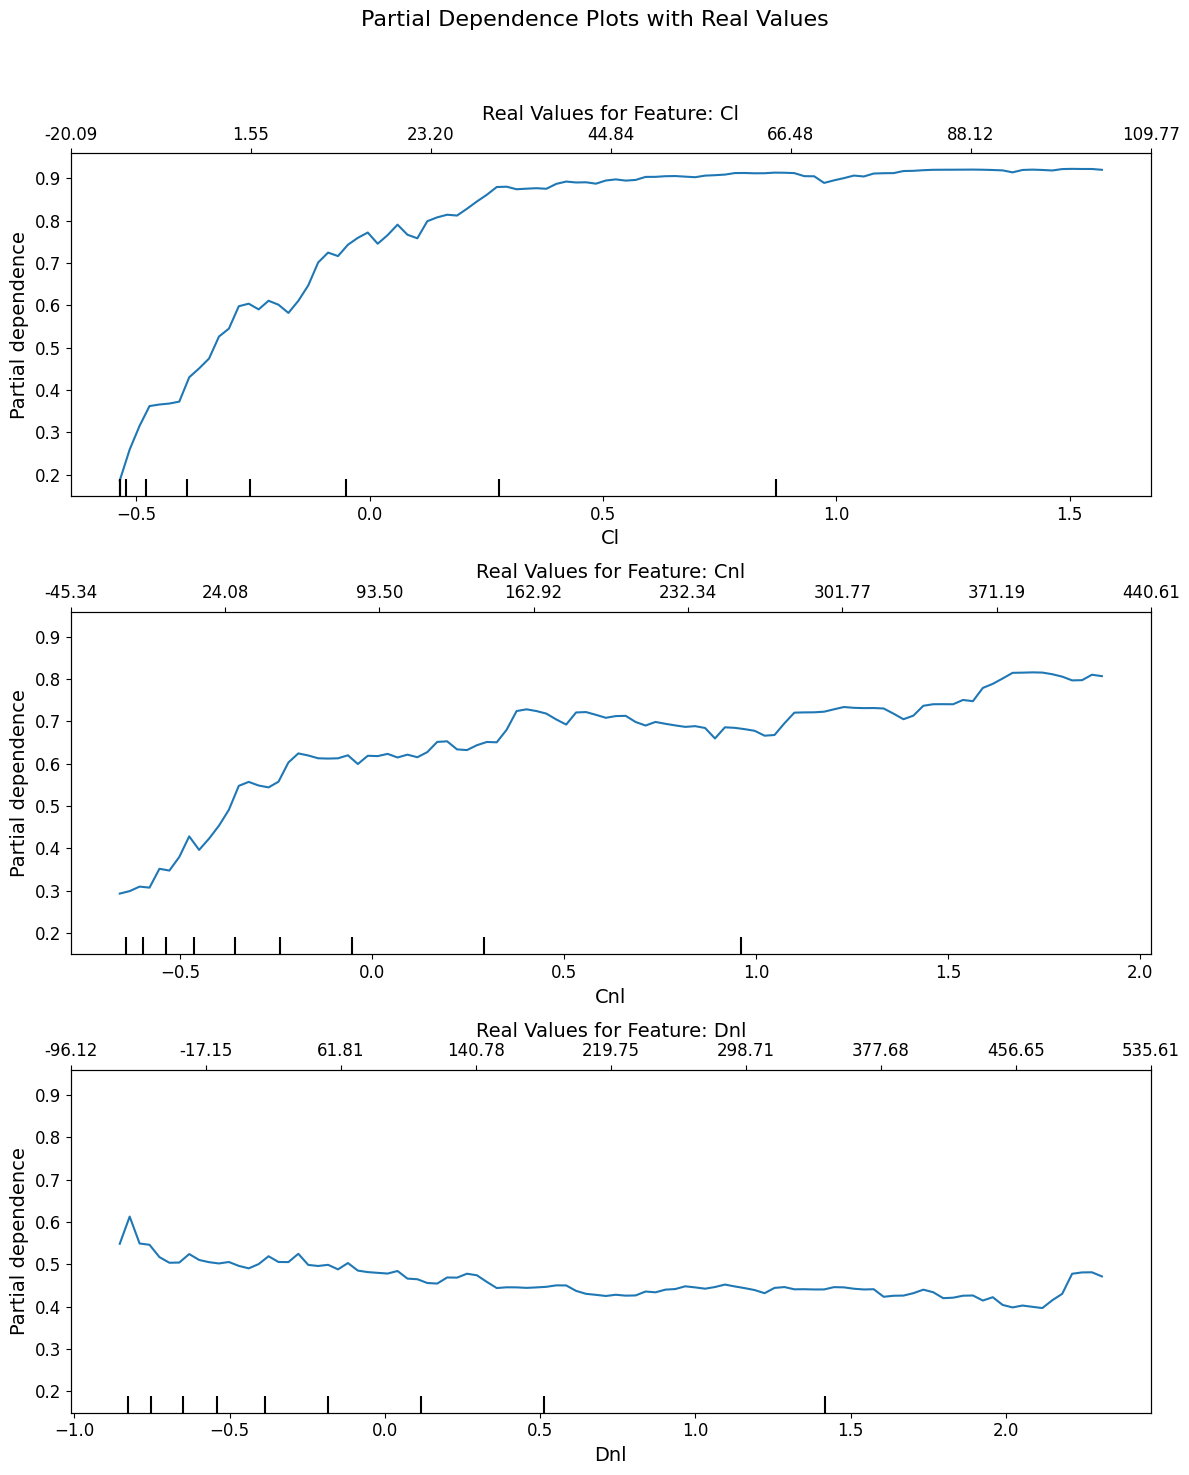

In [32]:
from sklearn.inspection import PartialDependenceDisplay

# Select the indices of the 3 most important variables
important_features_idx = feature_importances.index[:3]

# Create a figure and subplots
fig, ax = plt.subplots(len(important_features_idx), figsize=(12, 5 * len(important_features_idx)), sharex=False)

# Generate the PDP
display = PartialDependenceDisplay.from_estimator(
    final_model,
    X_test_scaled,
    important_features_idx,
    feature_names=X_train.columns,
    ax=ax
)

# Add secondary x-axes with the real values
for i, axis in enumerate(ax):
    # Identify the current feature
    feature_idx = important_features_idx[i]
    feature_name = X_train.columns[feature_idx]

    # Retrieve the x-axis limits from the PDP
    normalized_ticks = axis.get_xticks()  # Normalized ticks
    normalized_range = np.linspace(normalized_ticks.min(), normalized_ticks.max(), num=len(normalized_ticks)).reshape(-1, 1)

    # Build a matrix to transform only the corresponding column
    zero_matrix = np.zeros((normalized_range.shape[0], X_train.shape[1]))
    zero_matrix[:, feature_idx] = normalized_range.flatten()

    # Denormalize this column only
    denormalized_ticks = scaler.inverse_transform(zero_matrix)[:, feature_idx]

    # Create a secondary axis
    twin_ax = axis.twiny()
    twin_ax.set_xlim(axis.get_xlim())  # Synchronize limits with the main axis
    twin_ax.set_xlabel(f"Real Values for Feature: {feature_name}", fontsize=14)
    twin_ax.set_xticks(normalized_ticks)  # Same ticks as the main axis
    twin_ax.set_xticklabels([f"{val:.2f}" for val in denormalized_ticks])  # Real value mapping

# General title
plt.suptitle("Partial Dependence Plots with Real Values", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

We can see that the Dnl and Cnl features have a very flat curve. This indicates that these two variables have little effect on the predictions. On the contrary, Cl has a rising curve which shows that the greater the cumulative rainfall intensity during the trigger period, the greater the effect on predictions.

Still to do: find a way of finding a threshold intensity value

#### ROC Curve / AUC

The ROC curve illustrates the performance of a binary classification model. It can be very useful for comparing different models and for identifying an optimal threshold.

Area Under the ROC Curve (AUC): 0.9038


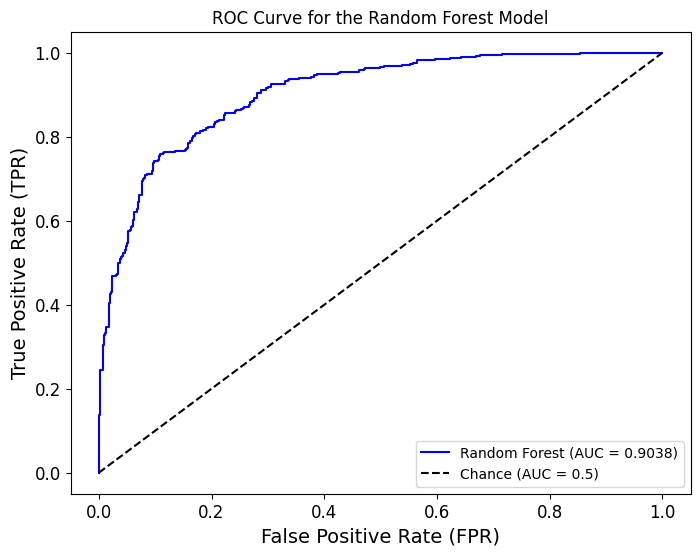

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute probabilities for the positive class (landslide)
y_test_proba_rf = final_model.predict_proba(X_test_scaled)[:, 1]

# Compute the values for the ROC curve
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_test_proba_rf)

# Compute the AUC
auc_score_rf = roc_auc_score(y_test, y_test_proba_rf)
print(f"Area Under the ROC Curve (AUC): {auc_score_rf:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_score_rf:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.5)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for the Random Forest Model")
plt.legend(loc="lower right")
plt.show()

We can see here that the curve is very far from the diagonal, which means that the model has worked rather well on these data. The area under the curve reaches 0.9038, which shows that the classification was not made randomly.

## XGBoost model

Let's move on to the second model I wanted to test: XGBoost. As explained earlier, this algorithm is more sophisticated than a Random Forest algorithm. I'll see if it performs better.

First, let's install the XGBoost library

In [41]:
!pip install xgboost

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:00:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test accuracy (XGBoost): 0.7963

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       459
           1       0.80      0.78      0.79       459

    accuracy                           0.80       918
   macro avg       0.80      0.80      0.80       918
weighted avg       0.80      0.80      0.80       918



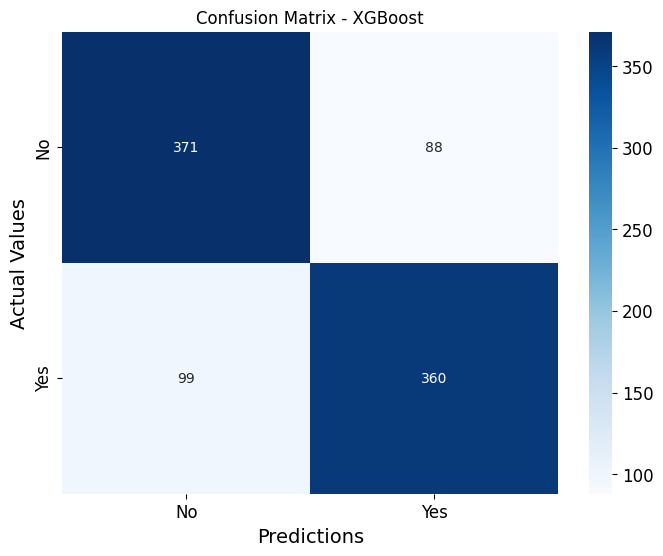

In [42]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model on the training dataset
xgb_model.fit(X_train_scaled, y_train)

# Predictions on the test set
y_test_pred = xgb_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy (XGBoost): {test_accuracy:.4f}")

# Display the classification report for detailed metrics
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_test_pred))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predictions")
plt.ylabel("Actual Values")
plt.show()


The performance of this model is no better than that of our random forest model. Accuracy on the test set is only 79.63 %

Area Under the ROC Curve (AUC) for XGBoost: 0.8872


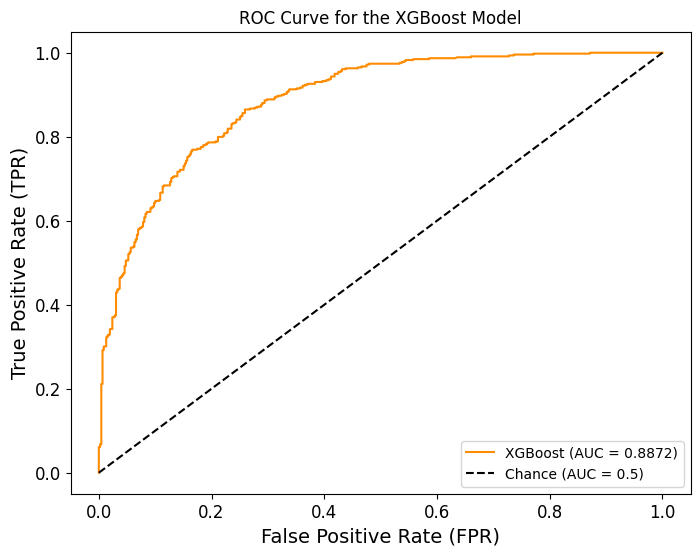

In [43]:
# Compute probabilities for the positive class
y_test_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Compute the values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Compute the AUC
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"Area Under the ROC Curve (AUC) for XGBoost: {auc_score:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.5)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for the XGBoost Model")
plt.legend(loc="lower right")
plt.show()

The ROC curve shows the same thing: the performance of the XGBoost model is not as good as our optimised Random Forest model. However, with an XGBoost model it is important to choose the hyperparameters carefully to obtain a high-performance model. That's why I'm now going to try and optimise my model using the same method as before with RandomizedSearchCV.

### Optimization XGBoost model

In [44]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define the hyperparameter search space
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 3, 5, 7]
}

# Create the base XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,  # number of random search iterations
    scoring='roc_auc',  # use AUC as the evaluation score
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # use all available cores to speed up the search
)

# Run RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Display the best hyperparameters and the best AUC performance
print("Best hyperparameters:", random_search.best_params_)
print("Best AUC score with the best hyperparameters:", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.001, 'gamma': 0.2, 'colsample_bytree': 1.0}
Best AUC score with the best hyperparameters: 0.8977177422504813


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:05:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Using the best parameters, I'm going to re-train the model.

In [46]:
# Retrieve the best hyperparameters
best_params = random_search.best_params_

# Create an XGBoost model with the best hyperparameters
best_xgb_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model on the training dataset
best_xgb_model.fit(X_train_scaled, y_train)

# Evaluate the model's performance on the test set
y_test_pred = best_xgb_model.predict(X_test_scaled)
y_test_proba_xgb = best_xgb_model.predict_proba(X_test_scaled)[:, 1]

# Compute the AUC and display the accuracy
auc_score_xgb = roc_auc_score(y_test, y_test_proba_xgb)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy with the best hyperparameters (XGBoost): {test_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:07:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test accuracy with the best hyperparameters (XGBoost): 0.8181


### Evaluation of the model's performance

#### Confusion Matrix

For this model too, I'm going to start by assessing its performance by plotting the confusion matrix

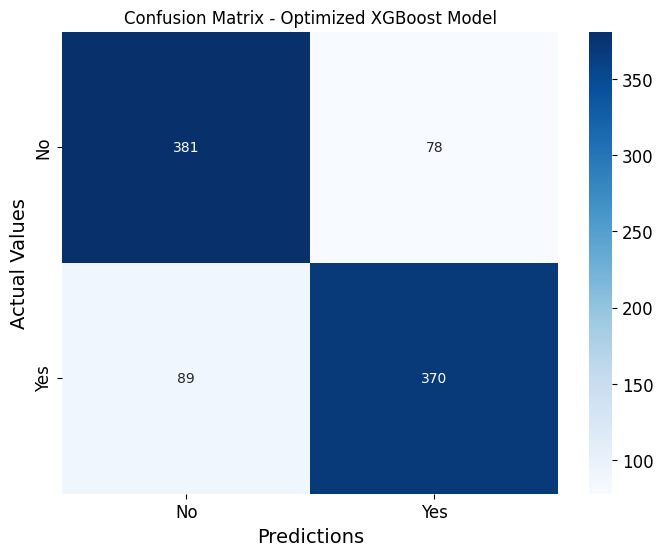

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on the test set with the optimized model
y_test_pred = best_xgb_model.predict(X_test_scaled)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix with annotations for easier interpretation
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No", "Yes"],
            yticklabels=["No", "Yes"])
plt.title("Confusion Matrix - Optimized XGBoost Model")
plt.xlabel("Predictions")
plt.ylabel("Actual Values")
plt.show()


The optimised model is better able to correctly determine which rainfall events caused landslides and which did not.

#### Features importances

  Feature  Importance (%)
2      Cl       73.643768
1     Cnl       21.944468
0     Dnl        4.411761


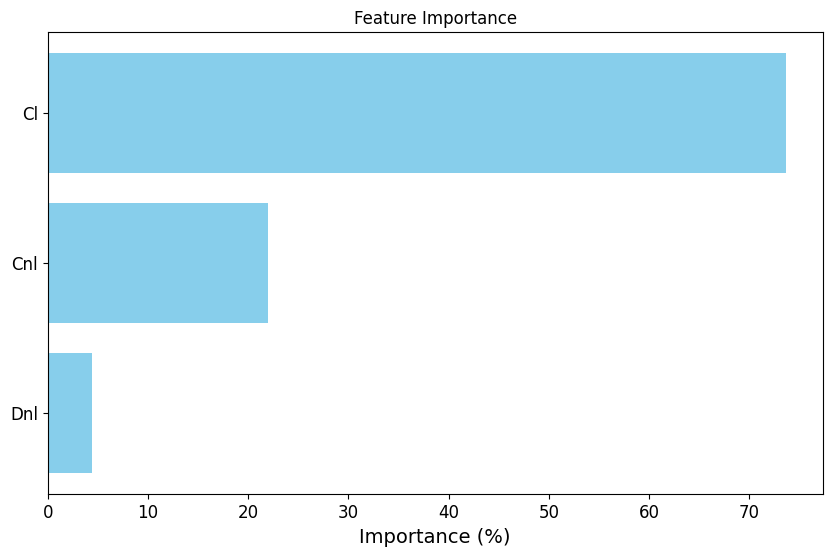

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importance
importances_xgb = best_xgb_model.feature_importances_

# Convert to percentage
importance_percentage = 100 * (importances_xgb / importances_xgb.sum())

# Create a DataFrame for easier visualization
features = X_train.columns  # Use the original column names
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance (%)': importance_percentage
}).sort_values(by='Importance (%)', ascending=False)

# Display feature importance
print(feature_importance_df)

# Plot a horizontal bar chart for feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance (%)'], color='skyblue')
plt.gca().invert_yaxis()  # Invert the y-axis so the most important features appear at the top
plt.xlabel('Importance (%)')
plt.title("Feature Importance")
plt.show()

The importance of the variables shows that it is also the cumulative intensity of the rain during the trigger period that is most important. But here it explains 73% of the results, whereas with the Random Forest model it explained only 53%.

### Partial Dependance Plot (PDP)

I also plot the PDP for the 3 features for the XGBoost model

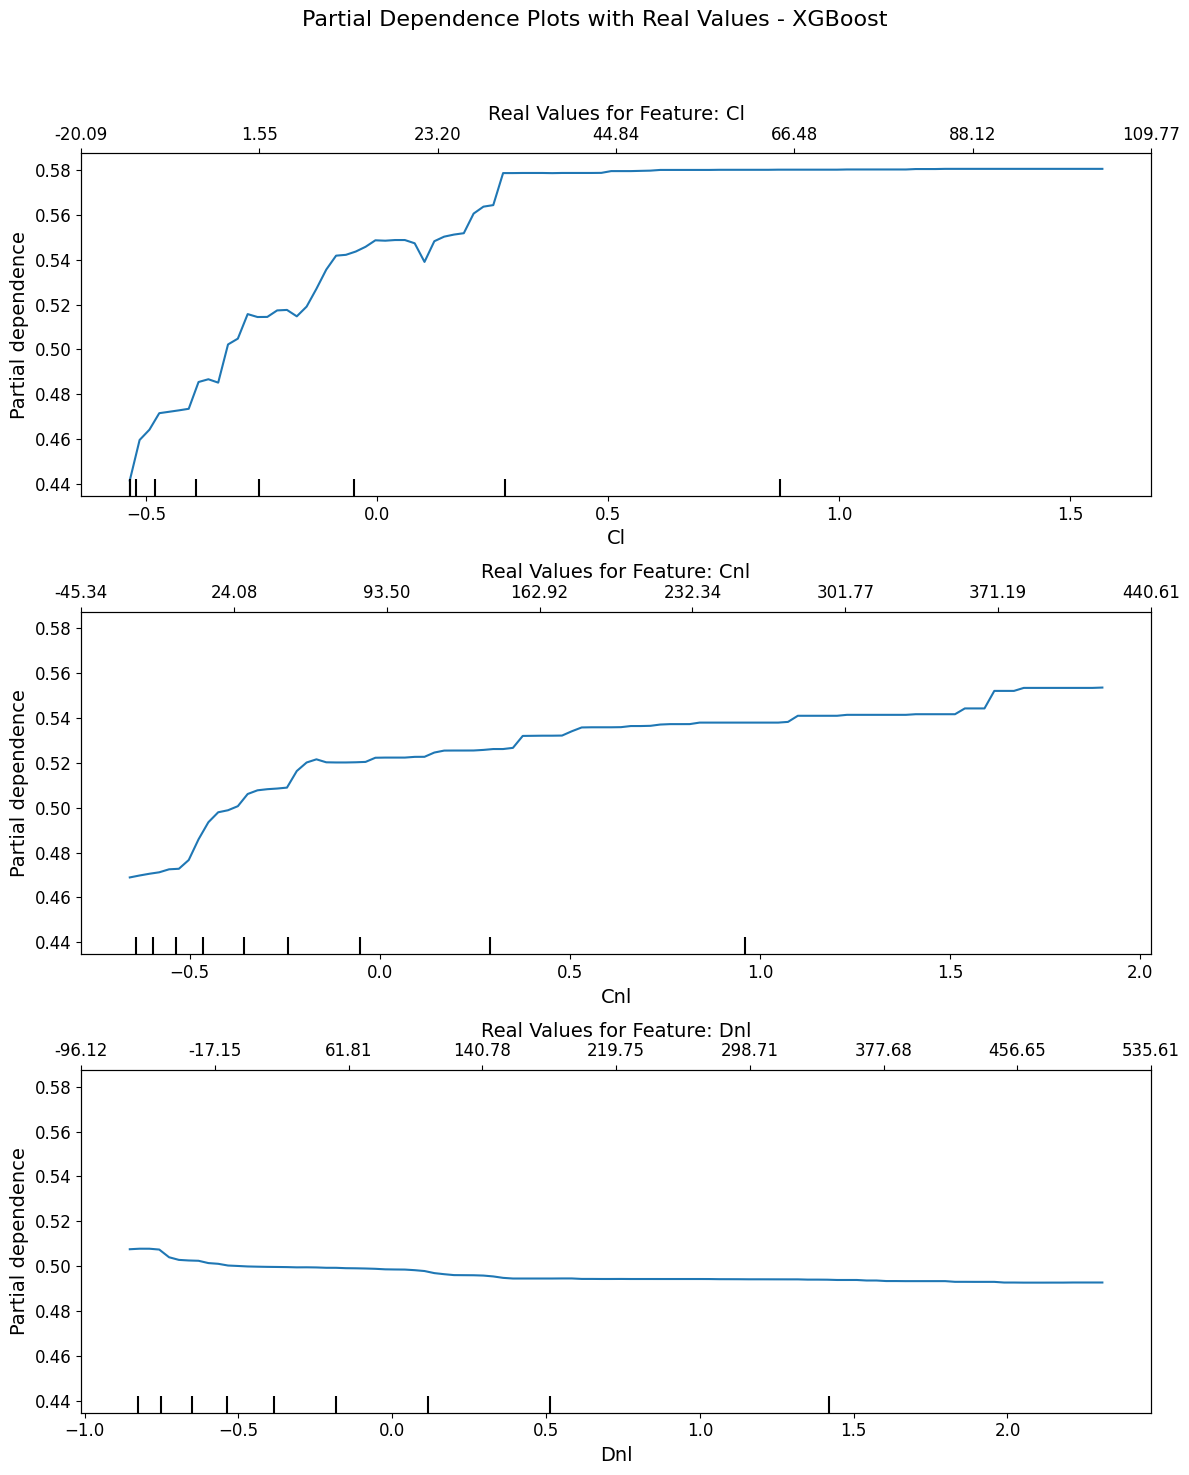

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import numpy as np

# Select the indices of the 3 most important features
important_features_idx = feature_importance_df.index[:3]

# Create a figure and subplots
fig, ax = plt.subplots(len(important_features_idx), figsize=(12, 5 * len(important_features_idx)), sharex=False)

# Generate the PDP with the XGBoost model
display = PartialDependenceDisplay.from_estimator(
    best_xgb_model,  # Use the XGBoost model
    X_test_scaled,  # Test data
    features=important_features_idx,  # Indices of the 3 most important features
    feature_names=X_train.columns,  # Feature names
    ax=ax
)

# Add secondary x-axes with real values
for i, axis in enumerate(ax):
    # Identify the current feature
    feature_idx = important_features_idx[i]
    feature_name = X_train.columns[feature_idx]

    # Retrieve the x-axis ticks from the PDP
    normalized_ticks = axis.get_xticks()  # Normalized ticks
    normalized_range = np.linspace(normalized_ticks.min(), normalized_ticks.max(), num=len(normalized_ticks)).reshape(-1, 1)

    # Create a matrix to transform only the corresponding column
    zero_matrix = np.zeros((normalized_range.shape[0], X_train_scaled.shape[1]))
    zero_matrix[:, feature_idx] = normalized_range.flatten()

    # Denormalize only this column
    denormalized_ticks = scaler.inverse_transform(zero_matrix)[:, feature_idx]

    # Create a secondary axis
    twin_ax = axis.twiny()
    twin_ax.set_xlim(axis.get_xlim())  # Synchronize limits with the main axis
    twin_ax.set_xlabel(f"Real Values for Feature: {feature_name}", fontsize=14)
    twin_ax.set_xticks(normalized_ticks)  # Same ticks as the main axis
    twin_ax.set_xticklabels([f"{val:.2f}" for val in denormalized_ticks])  # Real value mapping

# General title
plt.suptitle("Partial Dependence Plots with Real Values - XGBoost", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


To do again: See if it's normal to have a y axis that doesn't go from 0 to 1.

#### ROC Curve / AUC

Let's move on to the construction of the ROC curve

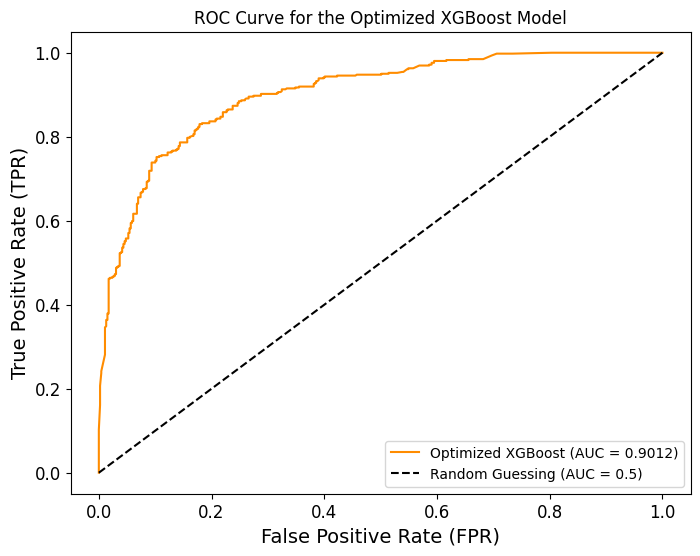

In [55]:
# Compute the ROC curve for the optimized model
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, y_test_proba_xgb)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'Optimized XGBoost (AUC = {auc_score_xgb:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing (AUC = 0.5)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for the Optimized XGBoost Model")
plt.legend(loc="lower right")
plt.show()

In terms of the ROC Curve, we can also see that performance is much better once the model has been optimised, with the area under the curve rising to over 0.9.

## Multi-Layer Perceptron (MLP)

The last algorithm to be tested is MLP. I'm going to start by creating a model as close as possible to the one created by the Italian researchers in their article ‘Deep learning forecast of rainfall-induced shallow landslides’. Since the architecture of their model is fairly simple, I've tried to create a more complex model to see if this improves performance.

### Splitting training/validation/test sets MLP

I decided to divide the data into 3 sets: training, validation and test, in the same way as the Italian researchers in their study. In other words :
1. Divide the rainfall data with and without landslides according to the same ratio: 80% - 20%.
2. 64% of the 80% of rainfall events with and without landslides will be used for training (2936 occurrences).
3. 16% of the 80% of rainfall events with and without landslides will be used for validation (734 occurences).
4. And the remaining 20% of rainfall events with and without landslides will be used for testing (918 occurences).

This split is only useful for MLP models if I want to optimise my hyperparameters with my validation set. However, since the RandomizedSearch method I use to optimise my hyperparameters for Random Forest and XGBoost models itself creates a validation set, I don't need to create one.

In [57]:
from sklearn.model_selection import train_test_split

# Separate the data into two groups: with landslides (bit_lan=1) and without landslides (bit_lan=0)
with_landslide = selected_SL[selected_SL['bit_lan'] == 1]
without_landslide = selected_SL[selected_SL['bit_lan'] == 0]

# 1. Divide each group into training/validation data (80%) and test data (20%)
with_landslide_train_val, with_landslide_test = train_test_split(with_landslide, test_size=0.2, random_state=42)
without_landslide_train_val, without_landslide_test = train_test_split(without_landslide, test_size=0.2, random_state=42)

# 2. Divide the training/validation package (80%) between training (64%) and validation (16%)
with_landslide_train, with_landslide_val = train_test_split(with_landslide_train_val, test_size=0.2, random_state=42)
without_landslide_train, without_landslide_val = train_test_split(without_landslide_train_val, test_size=0.2, random_state=42)

# 3. Combine training, validation and test data for the two classes (with and without landslides)
train_df = pd.concat([with_landslide_train, without_landslide_train], ignore_index=True)
val_df = pd.concat([with_landslide_val, without_landslide_val], ignore_index=True)
test_df = pd.concat([with_landslide_test, without_landslide_test], ignore_index=True)

# Display set sizes for verification
print(f"Size training set : {train_df.shape[0]}")
print(f"Size validation set : {val_df.shape[0]}")
print(f"Size test set : {test_df.shape[0]}")

Size training set : 2936
Size validation set : 734
Size test set : 918


It is necessary to create the matrix X and y, X being the explanatory variables, i.e. Dnl, Cnl, Cl, and y the target values, i.e. bit_lan. for training, test and validation

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Prepare the explanatory variables and the target variable
# The explanatory columns are Dnl, Cnl, Cl and the target variable is bit_lan

# For the training set
X_train = train_df[['Dnl', 'Cnl', 'Cl']]
y_train = train_df['bit_lan']

# For the validation set
X_val = val_df[['Dnl', 'Cnl', 'Cl']]
y_val = val_df['bit_lan']

# For the test set
X_test = test_df[['Dnl', 'Cnl', 'Cl']]
y_test = test_df['bit_lan']

Firstly, we need to normalise our data so that it can be fed into an artificial neural network algorithm such as an MLP. Normalisation allows the model to learn more efficiently by ensuring that the gradients are well proportioned between the different features.

In [59]:
from sklearn.preprocessing import StandardScaler

# Normalize the training, validation, and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Creation of the MLP model (Italian)

Let's start by creating an MLP model similar to the one created by the Italian researchers. I'm adding a random seed to reduce the variability of the results and increase the reproducibility of this work.

In [60]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Set a random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Create the fully connected model
mlp_custom_model = Sequential([
    Dense(4, activation='relu', input_shape=(3,)),  # Input layer with 3 variables and 4 neurons
    Dense(4, activation='relu'),                    # First hidden layer with 4 neurons
    Dense(4, activation='relu'),                    # Second hidden layer with 4 neurons
    Dense(1, activation='sigmoid')                  # Output layer with 1 neuron for probability
])

# Compile the model with a binary loss function
mlp_custom_model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

# Display the model summary to check weights and layers
mlp_custom_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 4)                   │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

The model can then be trained.

In [61]:
from tensorflow.keras.callbacks import EarlyStopping

# Initialize early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = mlp_custom_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,            # Maximum of 100 epochs
    batch_size=32,         # Batch size
    callbacks=[early_stopping],  # Early stopping
    verbose=1
)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5479 - loss: 0.6926 - val_accuracy: 0.6458 - val_loss: 0.6846
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6450 - loss: 0.6809 - val_accuracy: 0.7112 - val_loss: 0.6620
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6973 - loss: 0.6517 - val_accuracy: 0.7207 - val_loss: 0.6134
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7270 - loss: 0.5991 - val_accuracy: 0.7766 - val_loss: 0.5673
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7904 - loss: 0.5514 - val_accuracy: 0.7997 - val_loss: 0.5402
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8113 - loss: 0.5242 - val_accuracy: 0.8093 - val_loss: 0.5266
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8113 - loss: 0.5095 - val_accuracy: 0.8120 - val_loss: 0.5169
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8120 - loss: 0.4988 - val_accuracy: 0.8147 - v

In [62]:
# Display the weights and biases of each layer: I don’t know how to interpret this, and I’m not sure what it can be used for
for layer in mlp_custom_model.layers:
    weights, biases = layer.get_weights()
    print(f"Weights for layer {layer.name}:\n {weights}")
    print(f"Biases for layer {layer.name}:\n {biases}\n")

Weights for layer dense:
 [[ 0.59577113  0.05029177  0.00212939  0.7044375 ]
 [-0.78269076  0.62735677  0.89643514 -0.72815675]
 [ 0.13092041  0.49377513 -1.0613129  -0.6339673 ]]
Biases for layer dense:
 [ 0.0269824   0.7192399  -0.16980089  0.05930441]

Weights for layer dense_1:
 [[ 0.7629121  -0.21873373  0.5851897   0.6488078 ]
 [ 0.9140762  -1.2113891   0.42362595  0.2936448 ]
 [-0.7424521   0.5293767  -0.4571999  -0.12833345]
 [-0.14622754  0.3244312  -0.00681819 -0.7263848 ]]
Biases for layer dense_1:
 [ 0.45580104  0.48851892 -0.14666565  0.3716231 ]

Weights for layer dense_2:
 [[ 0.9256944   0.2797322   0.5020493  -0.5404945 ]
 [-1.5170417  -0.650729   -1.7255992  -0.10002209]
 [-0.8735004  -1.114744   -0.19297339  0.2509774 ]
 [ 0.33845258  1.3532122   0.7892755  -0.36713558]]
Biases for layer dense_2:
 [ 0.26246148 -0.00400331  0.49498346 -0.00562701]

Weights for layer dense_3:
 [[1.5136781 ]
 [0.927413  ]
 [1.0636318 ]
 [0.39483747]]
Biases for layer dense_3:
 [-2.555460

In [63]:
# Evaluate the model on the validation set
val_loss, val_accuracy = mlp_custom_model.evaluate(X_val_scaled, y_val)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Evaluate the model on the test set
test_loss, test_accuracy = mlp_custom_model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8260 - loss: 0.3853 
Validation Loss: 0.4207
Validation Accuracy: 0.8161
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8212 - loss: 0.3941
Test Loss: 0.3969
Test Accuracy: 0.8214


### Evaluation of the model's performance

Let's plot the confusion matrix, the ROC Curve and the importance of the variables to assess the performance of this model.

#### Confusion Matrix

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


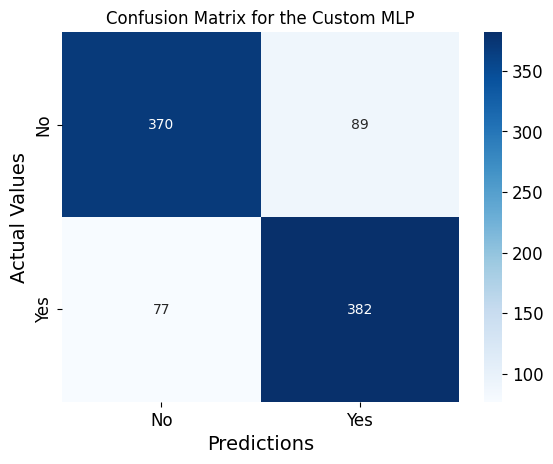

In [64]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Probability predictions
y_pred_proba_mlp_i = mlp_custom_model.predict(X_test_scaled).ravel()

# Confusion matrix
y_pred_mlp_custom = (y_pred_proba_mlp_i > 0.45).astype(int)
conf_matrix_mlp_custom = confusion_matrix(y_test, y_pred_mlp_custom)

sns.heatmap(conf_matrix_mlp_custom, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix for the Custom MLP')
plt.xlabel('Predictions')
plt.ylabel('Actual Values')
plt.show()

The confusion matrix is the best we've had so far. I lowered the standard decision threshold from 0.5 to 0.45 to avoid too many missed landslides.

#### ROC Curve /AUC

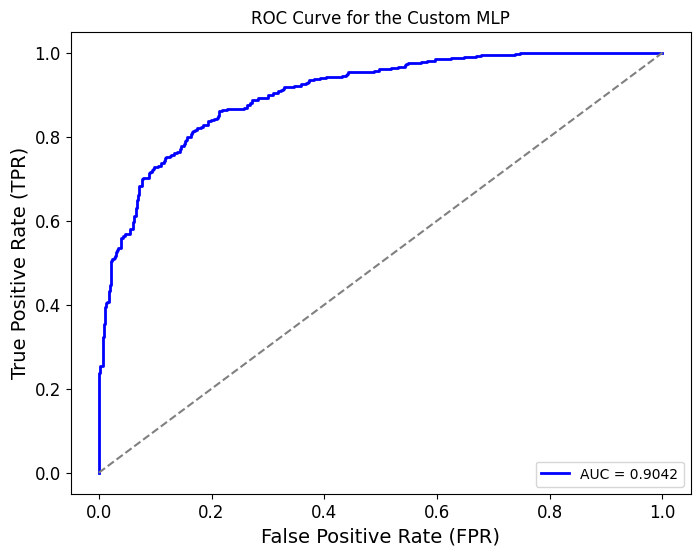

In [65]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr_mlp_i, tpr_mlp_i, thresholds = roc_curve(y_test, y_pred_proba_mlp_i)
auc_mlp_i = auc(fpr_mlp_i, tpr_mlp_i)

plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp_i, tpr_mlp_i, color='blue', lw=2, label=f'AUC = {auc_mlp_i:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for the Custom MLP')
plt.legend(loc='lower right')
plt.show()

The area under the ROC curve also performed well, at 0.9042.

#### Features importances

Knowing the importance of variables in an MLP model is not as straightforward as for previous models

To determine the importance of variables in an MLP model, we use a technique called permutation importance. This method consists of measuring the degradation in the model's performance when a variable is perturbed (for example, by randomly permuting it) while keeping the other variables intact. The greater the degradation in performance, the more important the variable is considered to be for the prediction of the model.

After calculating the importance of variables in an MLP model, I decide to normalise the results so that they are on a 100% scale. This allows me to easily compare the relative importance of variables between the Random Forest and XGBoost models.

In [66]:
# Fix the random seed for permutations
np.random.seed(42)

# Repeat permutations several times
n_repeats = 20  # Number of repetitions for each variable
features = ['Dnl', 'Cnl', 'Cl']

# Initial model evaluation on the test set
y_pred_initial_mlp_i = (mlp_custom_model.predict(X_test_scaled) > 0.5).astype(int)
initial_accuracy_mlp_i = accuracy_score(y_test, y_pred_initial_mlp_i)

# Initialize storage for average importances
importances_mlp_i = {i: [] for i in range(X_test_scaled.shape[1])}

# Loop through each column to measure feature importance
for repeat in range(n_repeats):
    for i in range(X_test_scaled.shape[1]):
        X_permuted = X_test_scaled.copy()
        np.random.shuffle(X_permuted[:, i])  # Shuffle with fixed seed
        y_pred_permuted = (mlp_custom_model.predict(X_permuted) > 0.5).astype(int)
        permuted_accuracy = accuracy_score(y_test, y_pred_permuted)
        importance = initial_accuracy_mlp_i - permuted_accuracy
        importances_mlp_i[i].append(importance)

# Compute average importances over the repetitions
mean_importances = {i: np.mean(importances_mlp_i[i]) for i in range(X_test_scaled.shape[1])}

# Normalize to get percentage
total_importance = sum(mean_importances.values())
normalized_importances = {i: (mean_importances[i] / total_importance) * 100 for i in range(X_test_scaled.shape[1])}

# Display importances
for i, importance in normalized_importances.items():
    print(f"Average importance of feature {features[i]}: {importance:.2f}%")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


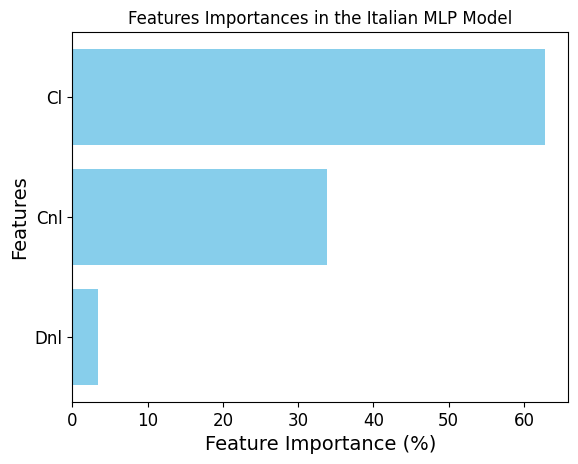

In [ ]:
import matplotlib.pyplot as plt

# Convert the dictionary to a sorted list (in descending order of importance)
features = ['Dnl', 'Cnl', 'Cl']
importances_values = [normalized_importances[i] for i in range(len(features))]

# Sort the importances and feature names
sorted_indices = np.argsort(importances_values)[::-1]  # Indices sorted in descending order
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = [importances_values[i] for i in sorted_indices]

# Create the bar chart
plt.barh(sorted_features, sorted_importances, color="skyblue")
plt.xlabel("Feature Importance (%)")
plt.ylabel("Features")
plt.title("Features Importances in the Italian MLP Model")
plt.gca().invert_yaxis()  # Invert the order to have the most important feature on top
plt.show()


Like the other models, the importance of the variables shows that the intensity of cumulative rainfall during the trigger period is the one that explains the results the most.

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━

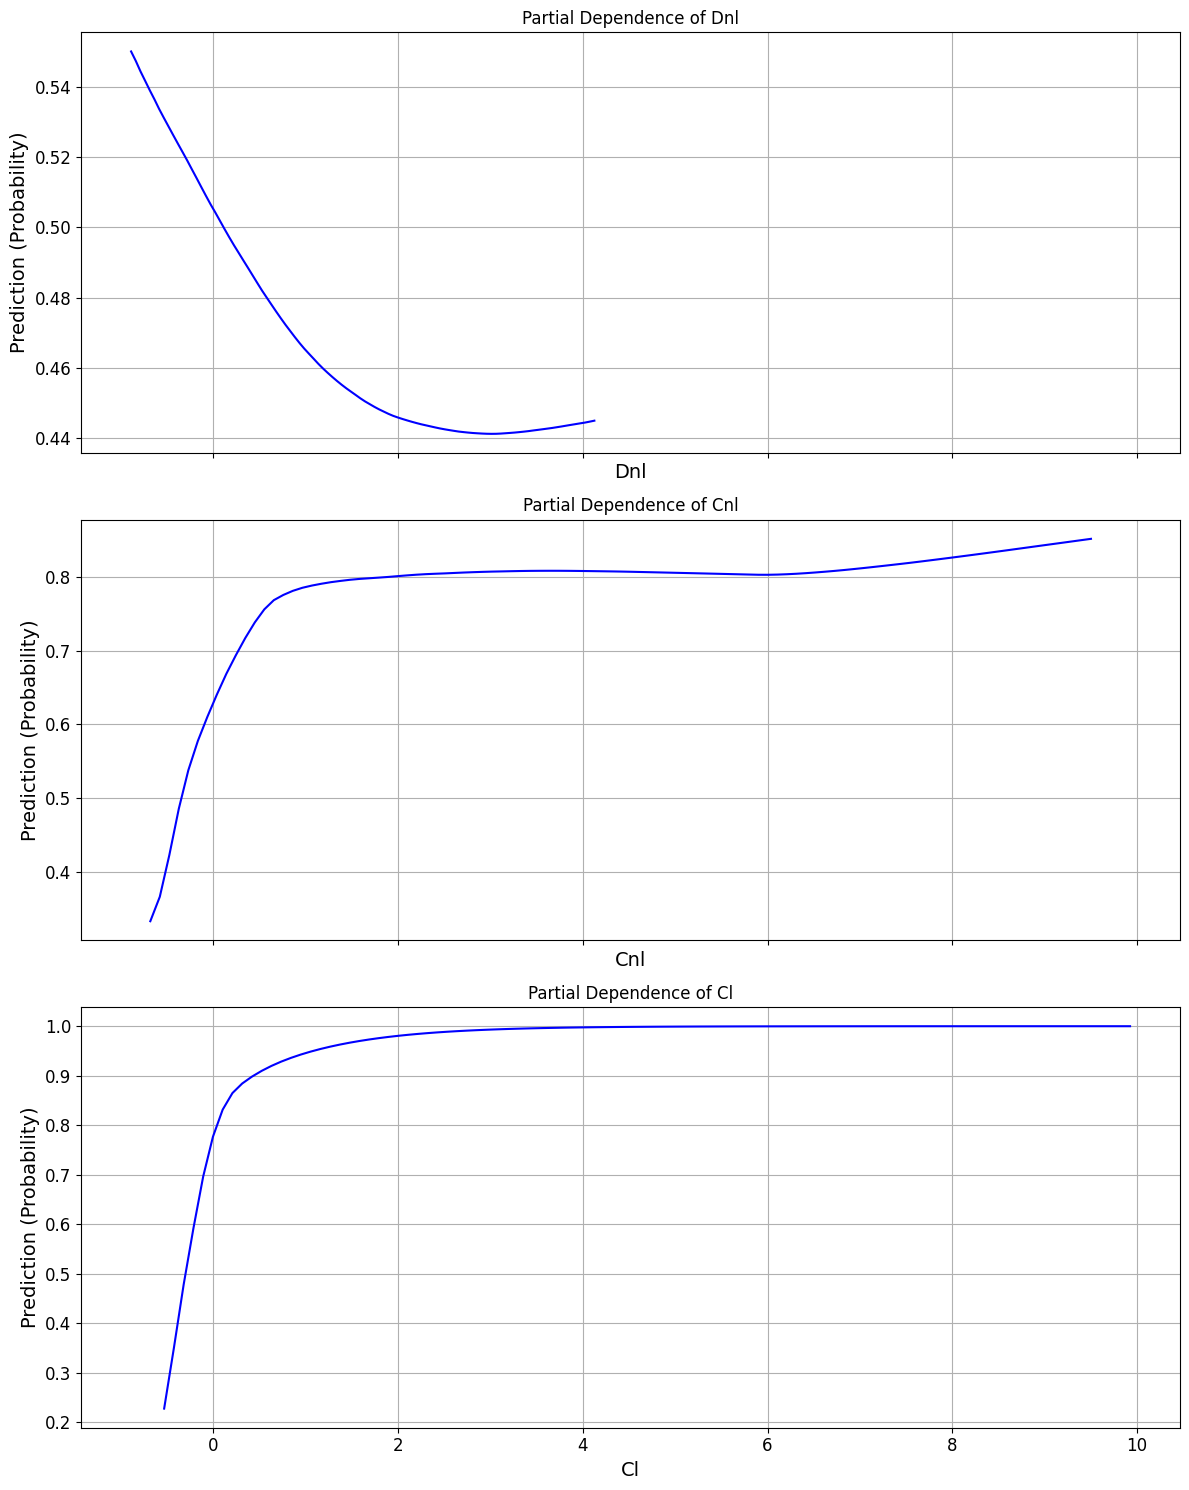

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose you have a fitted MLP model (mlp_custom_model) and test data (X_test_scaled)
# List the features to generate PDP for
feature_idx = [0, 1, 2]  # Replace with the actual indices of the features you want to plot

# Create a figure to hold the PDPs
fig, ax = plt.subplots(len(feature_idx), figsize=(12, 5 * len(feature_idx)), sharex=True)

# Loop over each feature index and create a PDP
for i, feature in enumerate(feature_idx):
    feature_name = X_test.columns[feature]  # Assuming you have feature names in X_test.columns

    # Create a range of values for this feature (e.g., from min to max in the test set)
    feature_range = np.linspace(X_test_scaled[:, feature].min(), X_test_scaled[:, feature].max(), 100)

    # Create an empty array to store the predicted values for the PDP
    pdp_values = np.zeros_like(feature_range)

    # For each value of the feature, create a copy of the data and set this feature to the current value
    for j, val in enumerate(feature_range):
        X_copy = X_test_scaled.copy()  # Copy of the data
        X_copy[:, feature] = val  # Set the feature of interest to the current value

        # Get the model's predictions for this modified data
        # For binary classification, use predict() to get probabilities
        pred = mlp_custom_model.predict(X_copy)[:, 0]  # Probability of the positive class (class 1)
        pdp_values[j] = np.mean(pred)  # Take the mean prediction for all samples

    # Plot the PDP for the current feature
    ax[i].plot(feature_range, pdp_values, label=f"PDP of {feature_name}", color='blue')
    ax[i].set_xlabel(feature_name)
    ax[i].set_ylabel('Prediction (Probability)')
    ax[i].set_title(f'Partial Dependence of {feature_name}')
    ax[i].grid(True)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
29/29 ━━

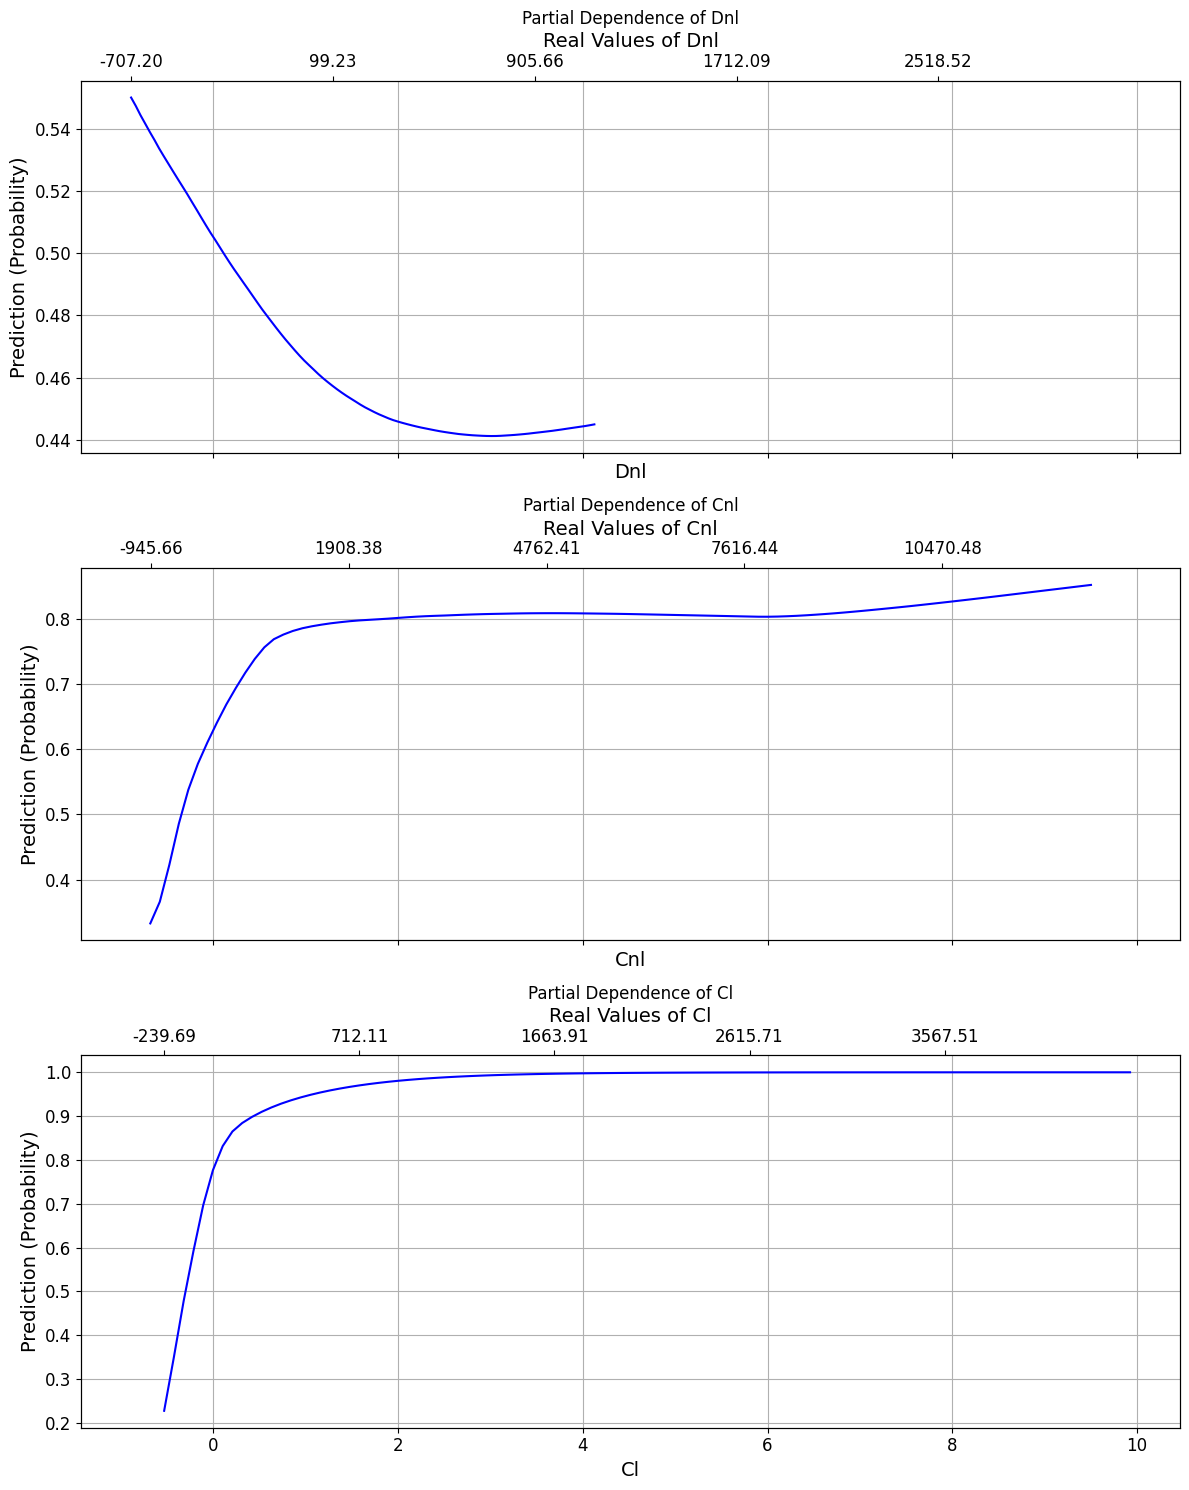

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose you have a fitted MLP model (mlp_custom_model) and test data (X_test_scaled)
# List the features to generate PDP for
feature_idx = [0, 1, 2]  # Replace with the actual indices of the features you want to plot

# Create a figure to hold the PDPs
fig, ax = plt.subplots(len(feature_idx), figsize=(12, 5 * len(feature_idx)), sharex=True)

# Loop over each feature index and create a PDP
for i, feature in enumerate(feature_idx):
    feature_name = X_test.columns[feature]  # Assuming you have feature names in X_test.columns

    # Create a range of values for this feature (e.g., from min to max in the test set)
    feature_range = np.linspace(X_test_scaled[:, feature].min(), X_test_scaled[:, feature].max(), 100)

    # Create an empty array to store the predicted values for the PDP
    pdp_values = np.zeros_like(feature_range)

    # For each value of the feature, create a copy of the data and set this feature to the current value
    for j, val in enumerate(feature_range):
        X_copy = X_test_scaled.copy()  # Copy of the data
        X_copy[:, feature] = val  # Set the feature of interest to the current value

        # Get the model's predictions for this modified data
        # For binary classification, use predict() to get probabilities
        pred = mlp_custom_model.predict(X_copy)[:, 0]  # Probability of the positive class (class 1)
        pdp_values[j] = np.mean(pred)  # Take the mean prediction for all samples

    # Plot the PDP for the current feature
    ax[i].plot(feature_range, pdp_values, label=f"PDP of {feature_name}", color='blue')
    ax[i].set_xlabel(feature_name)
    ax[i].set_ylabel('Prediction (Probability)')
    ax[i].set_title(f'Partial Dependence of {feature_name}')

    # Create the secondary x-axis (denormalized values)
    # We need to reverse the normalization (denormalize)
    feature_min = X_test.iloc[:, feature].min()
    feature_max = X_test.iloc[:, feature].max()
    feature_range_denorm = feature_range * (feature_max - feature_min) + feature_min

    # Create a secondary axis at the top of the plot
    twin_ax = ax[i].twiny()  # Create a secondary axis
    twin_ax.set_xlim(ax[i].get_xlim())  # Synchronize limits with the main axis
    twin_ax.set_xticks(feature_range)  # Set the ticks to match the normalized range

    # Limit the number of ticks to make the axis more readable
    tick_spacing = len(feature_range) // 5  # Show 5 ticks at most on the upper axis
    tick_indices = np.arange(0, len(feature_range), tick_spacing)  # Indices for ticks

    # Only show some ticks and the corresponding labels for real values
    twin_ax.set_xticks(feature_range[tick_indices])  # Set the ticks at the selected indices
    twin_ax.set_xticklabels([f"{val:.2f}" for val in feature_range_denorm[tick_indices]])  # Convert to real values

    twin_ax.set_xlabel(f"Real Values of {feature_name}", fontsize=14)

    ax[i].grid(True)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


### Creation of the MLP model (more complex architecture)

#### Test pour trouver les meilleurs paramètres pour le modèle MLP

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.5 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_layer1', min_value=16, max_value=128, step=16), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('units_layer2', min_value=16, max_value=128, step=16), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='mlp_tuning')

tuner.search(X_train_scaled, y_train, epochs=20, validation_data=(X_val_scaled, y_val))
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 10 Complete [00h 00m 22s]
val_accuracy: 0.8119890987873077

Best val_accuracy So Far: 0.8167575001716614
Total elapsed time: 00h 03m 55s


In [ ]:
# Récupérer le meilleur modèle
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres :")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

Meilleurs hyperparamètres :
units_layer1: 96
dropout_rate: 0.1
units_layer2: 32
learning_rate: 0.001


In [ ]:
# Construire le modèle avec les meilleurs hyperparamètres
best_model = tuner.hypermodel.build(best_hps)

In [ ]:
# Réentraîner le modèle avec les meilleurs hyperparamètres
history = best_model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6827 - loss: 0.5980 - val_accuracy: 0.7888 - val_loss: 0.4692
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7956 - loss: 0.4373 - val_accuracy: 0.8120 - val_loss: 0.4458
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8116 - loss: 0.4139 - val_accuracy: 0.8147 - val_loss: 0.4369
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8206 - loss: 0.4011 - val_accuracy: 0.8106 - val_loss: 0.4329
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8247 - loss: 0.3987 - val_accuracy: 0.8079 - val_loss: 0.4302
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8224 - loss: 0.3962 - val_accuracy: 0.8106 - val_loss: 0.4293
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8255 - loss: 0.3950 - val_accuracy: 0.8106 - val_loss: 0.4275
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8230 - loss: 0.3953 - val_accuracy: 0.8093 - v

In [ ]:
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8113 - loss: 0.3973
Test Loss: 0.3936
Test Accuracy: 0.8224


### MLP Model Creation

For this second MLP model, I also add a random seed as for the first model.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import random

# Set a random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Create the optimized model
model_optimized = Sequential([
    Dense(8, activation='relu', input_shape=(3,)),  # 8 neurons instead of 4
    Dropout(0.3),  # Adding dropout for regularization
    Dense(8, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='relu'),  # Adding a third hidden layer
    Dense(1, activation='sigmoid')  # Probability of landslide
])

# Compile the model with a more advanced optimizer and learning rate
model_optimized.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The model is then trained

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,          # Number of epochs without improvement before stopping
    restore_best_weights=True  # Restore the best weights found
)

# 2. Train the model
history = model_optimized.fit(X_train_scaled, y_train,
                              epochs=200,  # Adjustable based on needs
                              batch_size=16,  # Batch size for training
                              validation_data=(X_val_scaled, y_val),
                              verbose=1)

Epoch 1/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5831 - loss: 0.6640 - val_accuracy: 0.7425 - val_loss: 0.5995
Epoch 2/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6918 - loss: 0.6000 - val_accuracy: 0.7643 - val_loss: 0.5304
Epoch 3/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7221 - loss: 0.5486 - val_accuracy: 0.7970 - val_loss: 0.4817
Epoch 4/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7487 - loss: 0.5187 - val_accuracy: 0.8025 - val_loss: 0.4630
Epoch 5/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7404 - loss: 0.5100 - val_accuracy: 0.8065 - val_loss: 0.4585
Epoch 6/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7496 - loss: 0.5091 - val_accuracy: 0.8052 - val_loss: 0.4533
Epoch 7/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7583 - loss: 0.4914 - val_accuracy: 0.8079 - val_loss: 0.4487
Epoch 8/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7645 - loss: 0.4841 - val_accu

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model_optimized.evaluate(X_val_scaled, y_val)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Evaluate the model on the test set
test_loss, test_accuracy = model_optimized.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8441 - loss: 0.4242 
Validation Loss: 0.4279
Validation Accuracy: 0.8188
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8327 - loss: 0.4386 
Test Loss: 0.4090
Test Accuracy: 0.8246


### Evaluation of the model's performance

Let's plot the confusion matrix, the ROC Curve and the importance of the variables to assess the performance of this model.

#### Confusion matrix

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


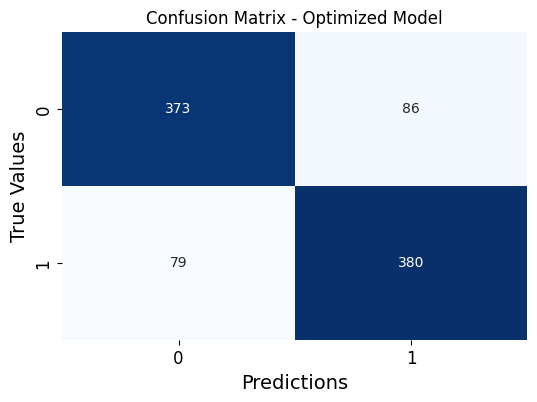

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       459
           1       0.82      0.83      0.82       459

    accuracy                           0.82       918
   macro avg       0.82      0.82      0.82       918
weighted avg       0.82      0.82      0.82       918



In [ ]:
# Model evaluation with a more complex architecture
# Predicting probabilities and classes
y_pred_proba_mlp_o = model_optimized.predict(X_test_scaled).ravel()
y_pred = (y_pred_proba_mlp_o > 0.48).astype(int)

# Computing the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Displaying the confusion matrix with labels
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predictions")
plt.ylabel("True Values")
plt.title("Confusion Matrix - Optimized Model")
plt.show()

# Classification report for additional metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

The confusion matrix is quite good, but not as good as the Italian MLP model. I also changed the probability threshold, but a threshold of 0.45 is too low to have good performances on both sides. So I increased it to 0.48 to get a better balance.

#### ROC Curve / AUC

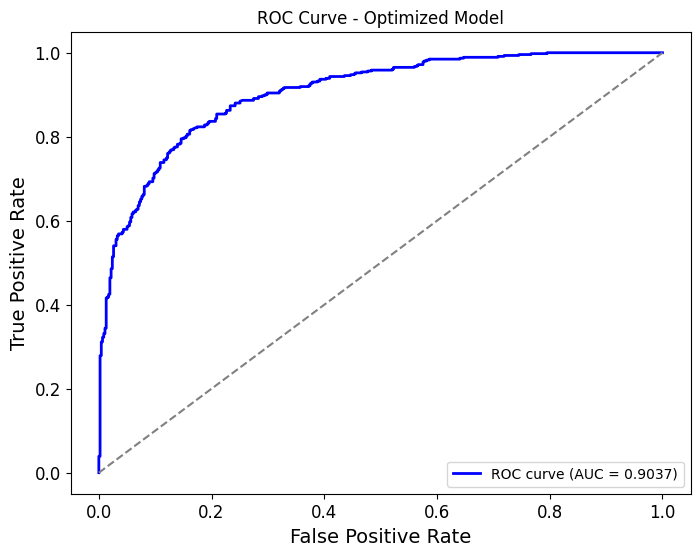

In [ ]:
# ROC curve and AUC calculation
fpr_mlp_o, tpr_mlp_o, thresholds = roc_curve(y_test, y_pred_proba_mlp_o)
auc_mlp_o = auc(fpr_mlp_o, tpr_mlp_o)

plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp_o, tpr_mlp_o, color='blue', lw=2, label=f'ROC curve (AUC = {auc_mlp_o:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Optimized Model")
plt.legend(loc="lower right")
plt.show()

#### Features Importances

The same method is used as before to find the importance of the variables.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Set the random seed for permutations
np.random.seed(42)

# Repeat the permutations multiple times
n_repeats = 20  # Number of repetitions for each variable
features = ['Dnl', 'Cnl', 'Cl']

# Initial model evaluation
y_pred_initial_mlp_o = (model_optimized.predict(X_test_scaled) > 0.5).astype(int)
initial_accuracy_mlp_o = accuracy_score(y_test, y_pred_initial_mlp_o)

# Initialization to store average importances
importances_mlp_o = {i: [] for i in range(X_test_scaled.shape[1])}

# Loop through each column to measure feature importance
for repeat in range(n_repeats):
    for i in range(X_test_scaled.shape[1]):
        X_permuted = X_test_scaled.copy()
        np.random.shuffle(X_permuted[:, i])  # Shuffle with fixed seed
        y_pred_permuted = (model_optimized.predict(X_permuted) > 0.5).astype(int)
        permuted_accuracy = accuracy_score(y_test, y_pred_permuted)
        importance = initial_accuracy_mlp_o - permuted_accuracy
        importances_mlp_o[i].append(importance)

# Average the importances over the repetitions
mean_importances = {i: np.mean(importances_mlp_o[i]) for i in range(X_test_scaled.shape[1])}

# Normalize to get percentage
total_importance = sum(mean_importances.values())
normalized_importances = {i: (mean_importances[i] / total_importance) * 100 for i in range(X_test_scaled.shape[1])}

# Display the importances
for i, importance in normalized_importances.items():
    print(f"Average importance of the variable {features[i]}: {importance:.2f}%")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/2

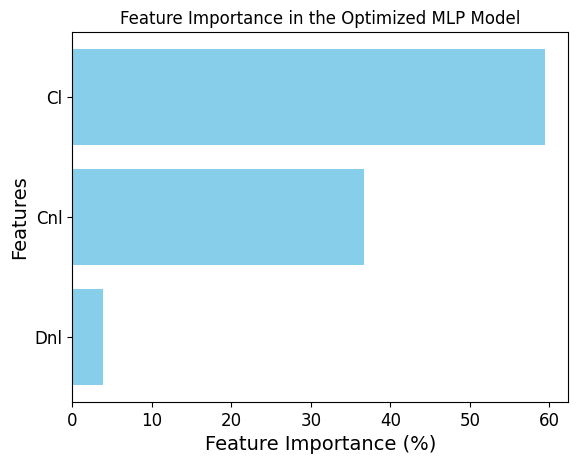

In [ ]:
import matplotlib.pyplot as plt

# Convert the dictionary into a sorted list (by descending importance)
features = ['Dnl', 'Cnl', 'Cl']
importances_values = [normalized_importances[i] for i in range(len(features))]

# Sort the importances and feature names
sorted_indices = np.argsort(importances_values)[::-1]  # Indices sorted in descending order
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = [importances_values[i] for i in sorted_indices]

# Create the bar plot
plt.barh(sorted_features, sorted_importances, color="skyblue")
plt.xlabel("Feature Importance (%)")
plt.ylabel("Features")
plt.title("Feature Importance in the Optimized MLP Model")
plt.gca().invert_yaxis()  # Reverse the order so the most important feature is at the top
plt.show()

## Summary figures

To better compare the different performances of the models, it is a good idea to create figures with all the models. I'll start with a figure that brings together all the ROC Curve and AUC values.

### ROC Curve and AUC

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


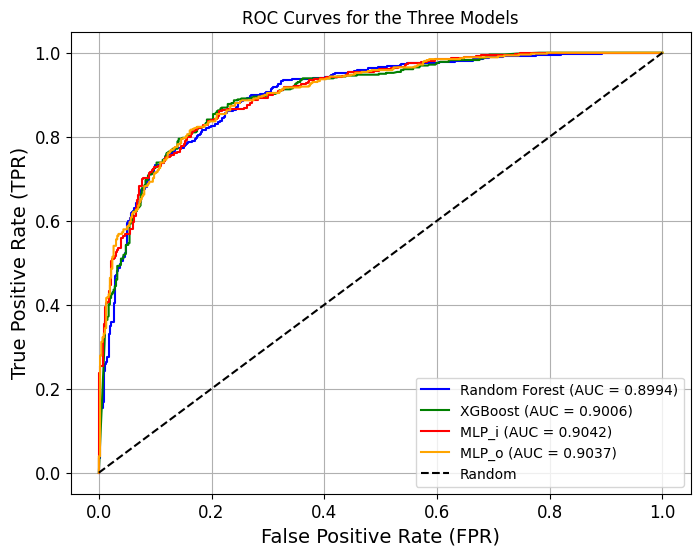

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assume you already have these elements for each model
# Random Forest Model
y_test_proba_rf = final_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
auc_rf = roc_auc_score(y_test, y_test_proba_rf)

# XGBoost Model
y_test_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_test_proba_xgb)

# Custom MLP Model (Italian)
y_test_proba_mlp_i = mlp_custom_model.predict(X_test_scaled).ravel()  # Use ravel() to flatten
fpr_mlp_i, tpr_mlp_i, _ = roc_curve(y_test, y_test_proba_mlp_i)
auc_mlp_i = roc_auc_score(y_test, y_test_proba_mlp_i)

# Optimized MLP Model
y_test_proba_mlp_o = model_optimized.predict(X_test_scaled).ravel()  # Use ravel() to flatten
fpr_mlp_o, tpr_mlp_o, _ = roc_curve(y_test, y_test_proba_mlp_o)
auc_mlp_o = roc_auc_score(y_test, y_test_proba_mlp_o)

# Plot ROC curves for all models on the same figure
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.4f})", color='blue')
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.4f})", color='green')
plt.plot(fpr_mlp_i, tpr_mlp_i, label=f"MLP_i (AUC = {auc_mlp_i:.4f})", color='red')
plt.plot(fpr_mlp_o, tpr_mlp_o, label=f"MLP_o (AUC = {auc_mlp_o:.4f})", color='orange')

# Add a diagonal line to indicate randomness
plt.plot([0, 1], [0, 1], 'k--', label="Random")

# Configure the plot
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves for the Three Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()

We can see that the 4 curves are very close to each other. The only way to differentiate them is by the AUC value. We can therefore see that the best model is the Italian model. I think that since the classification task is fairly simple, a simple model is enough to perform well.

### Features Importances

The importance of the features will also be compared in a graph

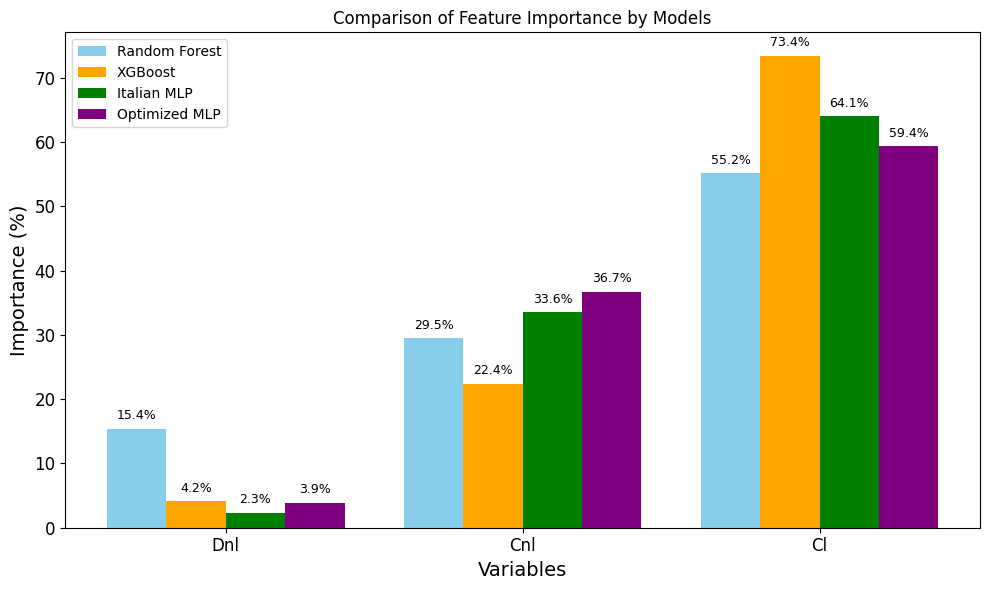

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importances for each model (these values are examples, replace them with your actual results)
features = ['Dnl', 'Cnl', 'Cl']

# Normalized feature importances by model (in percentage)
# Replace with actual results from each model
importances_rf = [15.38, 29.47, 55.16]  # Random Forest
importances_xgb = [4.15, 22.42, 73.43]  # XGBoost
importances_mlp_i = [2.32, 33.58, 64.09]  # Italian MLP
importances_mlp_o = [3.87, 36.73, 59.4]  # Optimized MLP

# Group the importances for the plot
all_importances = np.array([importances_rf, importances_xgb, importances_mlp_i, importances_mlp_o])

# Plot parameters
x = np.arange(len(features))  # Feature positions on the x-axis
width = 0.2  # Bar width

# Create the figure and bars
fig, ax = plt.subplots(figsize=(10, 6))
bar_rf = ax.bar(x - 1.5 * width, all_importances[0], width, label='Random Forest', color='skyblue')
bar_xgb = ax.bar(x - 0.5 * width, all_importances[1], width, label='XGBoost', color='orange')
bar_mlp_i = ax.bar(x + 0.5 * width, all_importances[2], width, label='Italian MLP', color='green')
bar_mlp_o = ax.bar(x + 1.5 * width, all_importances[3], width, label='Optimized MLP', color='purple')

# Add details to the plot
ax.set_xlabel('Variables')
ax.set_ylabel('Importance (%)')
ax.set_title("Comparison of Feature Importance by Models")
ax.set_xticks(x)
ax.set_xticklabels(features)
ax.legend()

# Add annotations above the bars
def add_annotations(bars, importances):
    for bar, importance in zip(bars, importances):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # Horizontal position (center of the bar)
            bar.get_height() + 1,              # Vertical position (just above the bar)
            f'{importance:.1f}%',              # Text to display
            ha='center', va='bottom', fontsize=9  # Alignment and font size
        )

add_annotations(bar_rf, importances_rf)
add_annotations(bar_xgb, importances_xgb)
add_annotations(bar_mlp_i, importances_mlp_i)
add_annotations(bar_mlp_o, importances_mlp_o)


# Display the plot
plt.tight_layout()
plt.show()
